In [2]:
"""
Visualization notebook for CaciqueAnalytics.
Primary chart type: radar charts for player comparison (2025 vs 2026).
Libraries:
  - mplsoccer: football-specific visualizations (radar, pitch plots)
  - matplotlib: base rendering and export
  - highlight_text: styled text annotations on charts
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Radar, FontManager
from pathlib import Path

PROC_PATH   = Path("../data/processed")
OUTPUT_PATH = Path("../outputs")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

df_2026 = pd.read_csv(PROC_PATH / "primera_division_2026_processed.csv")
df_2025 = pd.read_csv(PROC_PATH / "primera_division_2025_processed.csv")

print(f"2026 → {df_2026.shape}")
print(f"2025 → {df_2025.shape}")


2026 → (237, 88)
2025 → (416, 88)


In [41]:
"""
Reduced to 5-6 key metrics per position for social media readability.
Each metric selected to tell a clear story about the player's profile.
"""
RADAR_METRICS = {
    "Forwards": [
        "goals_p90",
        "totalShots_p90",
        "goalConversionPercentage",
        "successfulDribbles_p90",
        "assists_p90",
        "bigChancesMissed_p90",
    ],
    "Midfielders": [
        "accuratePassesPercentage",
        "keyPasses_p90",
        "bigChancesCreated_p90",
        "assists_p90",
        "interceptions_p90",
        "successfulDribbles_p90",
    ],
    "Defenders": [
        "clearances_p90",
        "interceptions_p90",
        "aerialDuelsWonPercentage",
        "groundDuelsWonPercentage",
        "accurateLongBalls_p90",
        "dribbledPast_p90",
    ],
    "Goalkeepers": [
        "saves_p90",
        "savedShotsFromInsideTheBox_p90",
        "goalsConcededInsideTheBox_p90",
        "highClaims_p90",
        "successfulRunsOut_p90",
        "accuratePassesPercentage",
    ]
}

print("Simplified metrics defined.")



Simplified metrics defined.


In [4]:
"""
Retrieves a player's stats row from a given season DataFrame.
Returns None if the player is not found.
"""
def get_player(df: pd.DataFrame, name: str) -> pd.Series | None:
    result = df[df["player"].str.lower() == name.lower()]
    if result.empty:
        print(f"Player not found: {name}")
        print("Available players with similar name:")
        print(df[df["player"].str.lower().str.contains(
            name.lower().split()[0])]["player"].values)
        return None
    return result.iloc[0]

# Test
print(get_player(df_2026, "Fernando Zampedri")[
    ["player", "team", "goals", "goals_p90", "minutesPlayed"]
])


player              Fernando Zampedri
team             Universidad Católica
goals                               6
goals_p90                         1.5
minutesPlayed                     360
Name: 196, dtype: object


In [42]:
"""
Human-readable Spanish labels mapped to each metric key.
Used exclusively for chart display — internal column names remain unchanged.
↓ indicates inverted metrics where lower value = better performance.
"""

METRIC_DESCRIPTIONS_ES = {

    # ── Scoring
    "goals_p90":                     "Goles p/90'",
    "goalConversionPercentage":      "Conversión %",
    "bigChancesMissed_p90":          "Chances\nfalladas p/90' ↓",

    # ── Shooting
    "totalShots_p90":                "Tiros p/90'",
    "shotsOnTarget_p90":             "Tiros al arco p/90'",

    # ── Creativity
    "bigChancesCreated_p90":         "Grandes chances\ncreadas p/90'",
    "assists_p90":                   "Asistencias p/90'",
    "keyPasses_p90":                 "Pases clave p/90'",

    # ── Passing (porcentajes — sin _p90)
    "accuratePassesPercentage":      "Pases\nprecisos %",
    "accurateLongBallsPercentage":   "Pelotas largas\nprecisas %",
    "accurateCrossesPercentage":     "Centros\nprecisos %",

    # ── Duels (porcentajes — sin _p90)
    "totalDuelsWonPercentage":       "Duelos\nganados %",
    "aerialDuelsWonPercentage":      "Duelos aéreos\nganados %",
    "groundDuelsWonPercentage":      "Duelos en piso\nganados %",

    # ── Dribbling
    "successfulDribbles_p90":        "Regates\nexitosos p/90'",

    # ── Defending
    "tackles_p90":                   "Entradas p/90'",
    "interceptions_p90":             "Intercepciones p/90'",
    "clearances_p90":                "Despejes p/90'",
    "blockedShots_p90":              "Tiros\nbloqueados p/90'",
    "dribbledPast_p90":              "Veces regateado p/90' ↓",

    # ── Discipline
    "foulsCommitted_p90":            "Faltas\ncometidas p/90' ↓",
    "wasFouled_p90":                 "Faltas\nrecibidas p/90'",
    "offsides_p90":                  "Fueras de\njuego p/90' ↓",

    # ── Goalkeeping
    "saves_p90":                     "Atajadas p/90'",
    "savedShotsFromInsideTheBox_p90":"Paradas dentro\ndel área p/90'",
    "goalsConcededInsideTheBox_p90": "Goles recibidos\ndentro del área ↓",
    "highClaims_p90":                "Salidas aéreas p/90'",
    "successfulRunsOut_p90":         "Salidas exitosas p/90'",
    "xgSave":                        "xG salvado",
    "cleanSheets":                   "Vallas invictas",

}


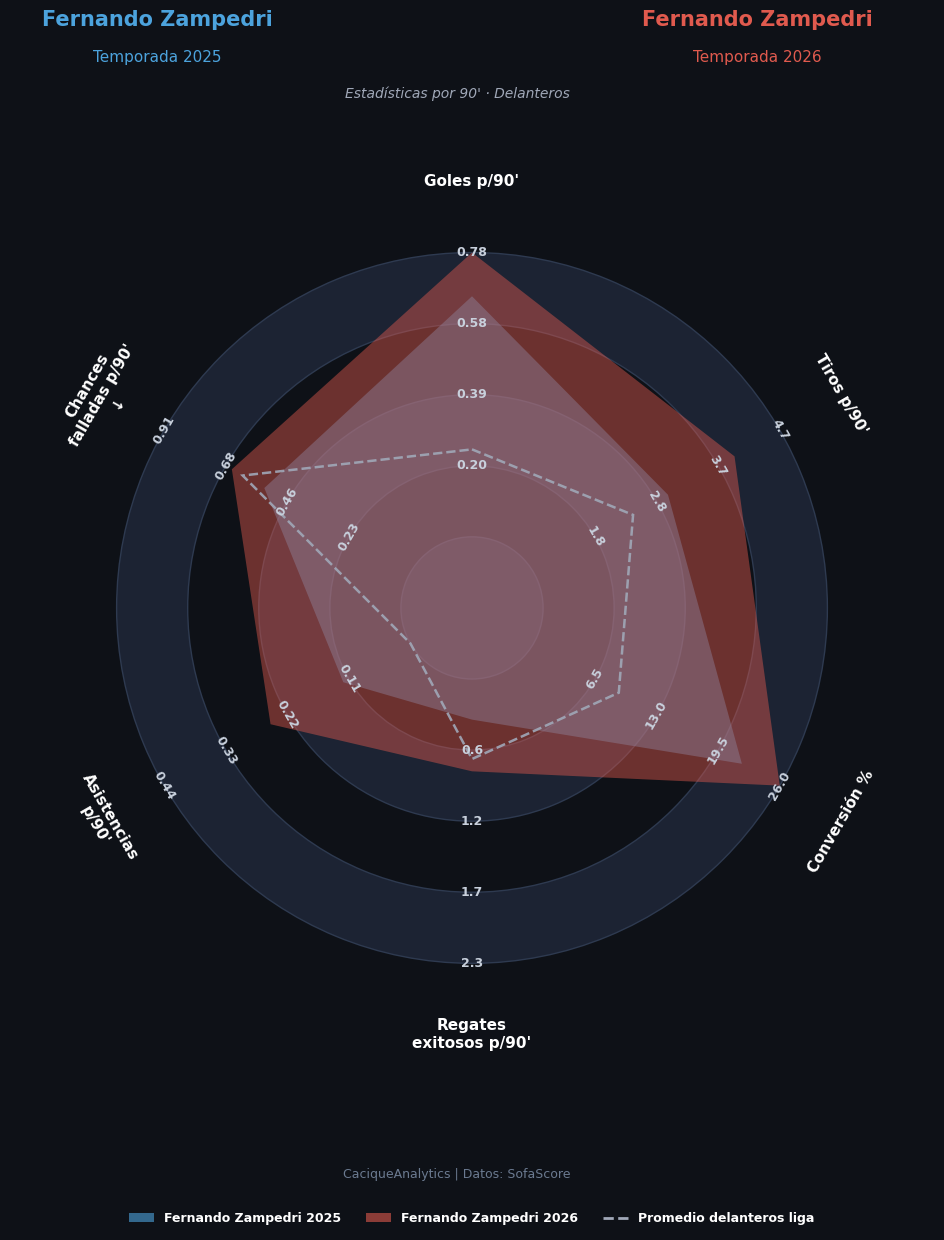

Saved → outputs/Fernando_Zampedri_2025_vs_Fernando_Zampedri_2026.png


In [ ]:
"""
Builds a dual-player radar chart with a dark theme for social media publishing.
Scale based on p5–p95 of the position pool across both seasons.
A dashed league median polygon serves as the visual reference baseline.
Metrics where lower = better are inverted so the outer ring always means better.
"""
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

POSITION_ES = {
    "Forwards":    "Delanteros",
    "Midfielders": "Mediocampistas",
    "Defenders":   "Defensores",
    "Goalkeepers": "Porteros"
}

# Metrics where a lower value means better — inverted so outer ring = better
INVERT_COLS = {
    "foulsCommitted_p90",
    "offsides_p90",
    "goalsConcededInsideTheBox_p90",
    "dribbledPast_p90",
}

def build_radar(player1_name: str, season1: str,
                player2_name: str, season2: str,
                position: str) -> None:

    df1 = df_2026 if season1 == "2026" else df_2025
    df2 = df_2026 if season2 == "2026" else df_2025

    p1 = get_player(df1, player1_name)
    p2 = get_player(df2, player2_name)
    if p1 is None or p2 is None:
        return

    metrics  = RADAR_METRICS[position]
    all_data = pd.concat([
        df_2026[df_2026["position"] == position],
        df_2025[df_2025["position"] == position]
    ])

    PCT_COLS = {
        "goalConversionPercentage", "accuratePassesPercentage",
        "accurateCrossesPercentage", "accurateLongBallsPercentage",
        "totalDuelsWonPercentage", "aerialDuelsWonPercentage",
        "groundDuelsWonPercentage"
    }

    low  = [int(round(all_data[m].quantile(0.05))) if m in PCT_COLS
            else round(all_data[m].quantile(0.05), 2) for m in metrics]
    high = [int(round(all_data[m].quantile(0.95))) if m in PCT_COLS
            else round(all_data[m].quantile(0.95), 2) for m in metrics]
    median = [int(round(all_data[m].median())) if m in PCT_COLS
              else round(all_data[m].median(), 2) for m in metrics]

    vals1 = [int(round(p1[m])) if m in PCT_COLS else round(p1[m], 2) for m in metrics]
    vals2 = [int(round(p2[m])) if m in PCT_COLS else round(p2[m], 2) for m in metrics]

    # Invert lower-is-better metrics so outer ring always means better
    for i, m in enumerate(metrics):
        if m in INVERT_COLS:
            lo, hi = low[i], high[i]
            vals1[i]  = round(lo + hi - vals1[i],  2)
            vals2[i]  = round(lo + hi - vals2[i],  2)
            median[i] = round(lo + hi - median[i], 2)

    labels = [METRIC_DESCRIPTIONS_ES.get(m, METRIC_LABELS_ES.get(m, m)) for m in metrics]

    # ── Dark theme palette ────────────────────────────────────────────────────
    BG_COLOR     = "#0E1117"
    RING_COLOR   = "#1C2333"
    EDGE_COLOR   = "#2E3A50"
    COLOR_P1     = "#4CA3DD"
    COLOR_P2     = "#E05A4E"
    COLOR_AVG    = "#A0A8B8"
    LABEL_COLOR  = "#FFFFFF"
    RANGE_COLOR  = "#C8D0DC"
    CREDIT_COLOR = "#6B7A90"

    radar = Radar(labels, low, high, num_rings=4, ring_width=1, center_circle_radius=1)
    fig, ax = radar.setup_axis()
    fig.set_facecolor(BG_COLOR)
    ax.set_facecolor(BG_COLOR)

    radar.draw_circles(ax=ax, facecolor=RING_COLOR, edgecolor=EDGE_COLOR, lw=1)

    # Ring scale numbers
    radar.draw_range_labels(ax=ax, fontsize=9, color=RANGE_COLOR, fontweight="bold")

    radar.draw_radar_compare(
        vals1, vals2, ax=ax,
        kwargs_radar={"facecolor": COLOR_P1, "alpha": 0.45},
        kwargs_compare={"facecolor": COLOR_P2, "alpha": 0.45}
    )

    # League median polygon — dashed outline, no fill
    radar.draw_radar_solid(median, ax=ax,
                           kwargs={"facecolor": "none",
                                   "edgecolor": COLOR_AVG,
                                   "linewidth": 1.8,
                                   "linestyle": "--",
                                   "alpha": 0.9})

    radar.draw_param_labels(ax=ax, fontsize=11, color=LABEL_COLOR, fontweight="bold")

    # ── Header ────────────────────────────────────────────────────────────────
    fig.text(0.25, 0.98, player1_name,
             color=COLOR_P1, fontsize=15, fontweight="bold", ha="center")
    fig.text(0.25, 0.95, f"Temporada {season1}",
             color=COLOR_P1, fontsize=11, ha="center")
    fig.text(0.75, 0.98, player2_name,
             color=COLOR_P2, fontsize=15, fontweight="bold", ha="center")
    fig.text(0.75, 0.95, f"Temporada {season2}",
             color=COLOR_P2, fontsize=11, ha="center")
    fig.text(0.5, 0.92, f"Estadísticas por 90' · {POSITION_ES.get(position, position)}",
             color=COLOR_AVG, fontsize=10, ha="center", style="italic")

    # ── Legend ────────────────────────────────────────────────────────────────
    pos_es = POSITION_ES.get(position, position)
    legend_elements = [
        Patch(facecolor=COLOR_P1, alpha=0.6, label=f"{player1_name} {season1}"),
        Patch(facecolor=COLOR_P2, alpha=0.6, label=f"{player2_name} {season2}"),
        Line2D([0], [0], color=COLOR_AVG, linewidth=2,
               linestyle="--", label=f"Promedio {pos_es.lower()} liga"),
    ]
    legend = ax.legend(handles=legend_elements, loc="lower center",
                       bbox_to_anchor=(0.5, -0.18), ncol=3,
                       frameon=False, fontsize=9, labelcolor=LABEL_COLOR)
    for text in legend.get_texts():
        text.set_fontweight("bold")

    # ── Footer ────────────────────────────────────────────────────────────────
    fig.text(0.5, 0.02, "CaciqueAnalytics | Datos: SofaScore",
             color=CREDIT_COLOR, fontsize=9, ha="center")

    filename = (f"{player1_name.replace(' ', '_')}_{season1}"
                f"_vs_{player2_name.replace(' ', '_')}_{season2}.png")
    fig.savefig(OUTPUT_PATH / filename, dpi=150,
                bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()
    print(f"Saved → outputs/{filename}")


build_radar("Fernando Zampedri", "2025", "Fernando Zampedri", "2026", "Forwards")
